# Predicting the Popularity of Venues in Downtown Toronto

__TODO__: Add description of the project (it can be the same description as the one in the assignment)

## Import the necessary libraries

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np
import scipy as sp

from scipy.spatial import distance  # distance matrix computations
from scipy.cluster import hierarchy  # hierarchical clustering

from sklearn.preprocessing import MinMaxScaler  # used to normalize data

import networkx as nx  # plot graphs

import requests  # handle requests

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import pylab  # plotting dendograms
import seaborn as sns  # plotting in general
import branca  # add legend to folium map

import folium  # map rendering library

import geopandas  # DataFrame to GeoJSON

import warnings

C:\Users\diego\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Get the traffic data from the Toronto Open Data API

In [2]:
# Get the dataset metadata by passing package_id to the package_search endpoint
# For example, to retrieve the metadata for this dataset:
url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show"
payload = {"id": "ae4e10a2-9eaf-4da4-83fb-f3731a30c124"}
response = requests.get(url, params=payload).json()
traffic_df = pd.read_excel(response["result"]['resources'][0]['url'])
traffic_df.head()

TCS #       Main Midblock Route   Side 1 Route Side 2 Route  \
0      2  JARVIS ST            NaN     FRONT ST E          NaN   
1      3  KING ST E            NaN      JARVIS ST          NaN   
2      4  JARVIS ST            NaN  ADELAIDE ST E          NaN   
3      5  JARVIS ST            NaN  RICHMOND ST E          NaN   
4      6  JARVIS ST            NaN     QUEEN ST E          NaN   

  Activation Date   Latitude  Longitude Count Date  8 Peak Hr Vehicle Volume  \
0      11/15/1948  43.649418 -79.371446 2017-06-21                     15662   
1      08/23/1950  43.650461 -79.371924 2016-09-17                     12960   
2      09/12/1958  43.651534 -79.372360 2016-11-08                     17770   
3      04/21/1962  43.652718 -79.372824 2015-12-08                     19678   
4      08/24/1928  43.653704 -79.373238 2016-09-17                     14487   

   8 Peak Hr Pedestrian Volume  
0                        13535  
1                         7333  
2                         7083  
3                         4369  
4                         3368

## Clean the traffic data

Drop and rename some of the columns to make the table easier to work with.

In [3]:
col_rename = {'Side 1 Route': 'Side1',
              '8 Peak Hr Vehicle Volume': 'VehicleVolume',
              '8 Peak Hr Pedestrian Volume': 'PedestrianVolume'}
traffic_df.drop(['TCS #', 'Midblock Route', 'Side 2 Route', 'Activation Date', 'Count Date'], axis=1, inplace=True)
traffic_df.rename(columns=col_rename, inplace=True)

# add column with the intersection name
intersections = traffic_df.loc[:, 'Main'] + ' & ' + traffic_df.loc[:, 'Side1']
traffic_df.loc[:, 'Intersection'] = intersections

traffic_df.head()

Main          Side1   Latitude  Longitude  VehicleVolume  \
0  JARVIS ST     FRONT ST E  43.649418 -79.371446          15662   
1  KING ST E      JARVIS ST  43.650461 -79.371924          12960   
2  JARVIS ST  ADELAIDE ST E  43.651534 -79.372360          17770   
3  JARVIS ST  RICHMOND ST E  43.652718 -79.372824          19678   
4  JARVIS ST     QUEEN ST E  43.653704 -79.373238          14487   

   PedestrianVolume               Intersection  
0             13535     JARVIS ST & FRONT ST E  
1              7333      KING ST E & JARVIS ST  
2              7083  JARVIS ST & ADELAIDE ST E  
3              4369  JARVIS ST & RICHMOND ST E  
4              3368     JARVIS ST & QUEEN ST E

Let's look at the minimum and maximum values of each numeric column to see if we need to clean up further.

In [4]:
def MinMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

traffic_df._get_numeric_data().apply(MinMax)

Latitude  Longitude  VehicleVolume  PedestrianVolume
min  43.591686 -79.639290           1081                 0
max  43.855450 -73.389642          56432             47561

We see that there is at least one intersection where the pedestrian volume is zero. We don't want to consider intersections where there is none to very little pedestrian traffic. Let's now look at the distribution of pedestrian volume in the city.

In [5]:
traffic_df.drop(traffic_df[traffic_df['PedestrianVolume'] == 0].index, inplace=True)

(223,)


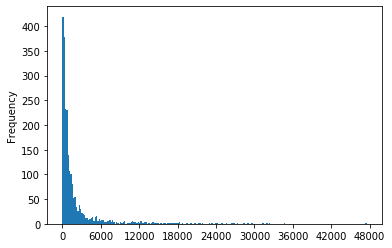

In [6]:
num_bins = round(traffic_df.shape[0]/10)
data = traffic_df['PedestrianVolume']
print(traffic_df.loc[traffic_df['PedestrianVolume'] > 5000]['PedestrianVolume'].shape)

fig, ax = plt.subplots()
data.plot.hist(bins=num_bins)
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.show()

The plot below shows a scatter plot of the latitudes and longitudes in the data. This should have roughly the shape of the city, but we see that there is an outlier to the right of -74 degrees of longitude. We are not interested in an intersection that is far away from the core of the city. as such, remove any intersections that have a degree of longitude greater than 74 degrees of longitude, and re-plot to see the corrected data.

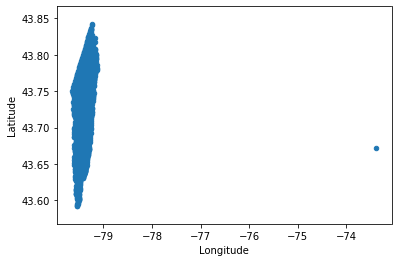

In [7]:
traffic_df.plot(kind='scatter', x='Longitude', y='Latitude')

In [8]:
traffic_df.drop(traffic_df[traffic_df['Longitude'] > -74].index, inplace=True)
traffic_df.reset_index(drop=True, inplace=True)

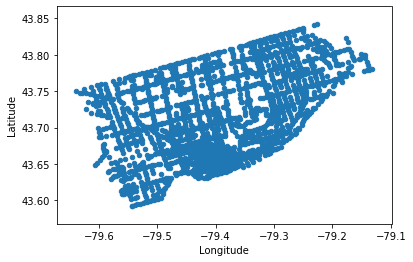

In [9]:
traffic_df.plot(kind='scatter', x='Longitude', y='Latitude')

We see that the plot now resembles the shape of the city.

## Get the neighbourhood data from the Open Data Toronto website

In [51]:
neighbourhoods_gdf = geopandas.read_file('https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/a083c865-6d60-4d1d-b6c6-b0c8a85f9c15?format=geojson&projection=4326')
neighbourhoods_gdf.head()

_id   AREA_ID  AREA_ATTR_ID  PARENT_AREA_ID  AREA_SHORT_CODE  \
0  5041  25886861      25926662           49885               94   
1  5042  25886820      25926663           49885              100   
2  5043  25886834      25926664           49885               97   
3  5044  25886593      25926665           49885               27   
4  5045  25886688      25926666           49885               31   

   AREA_LONG_CODE                     AREA_NAME                     AREA_DESC  \
0              94                 Wychwood (94)                 Wychwood (94)   
1             100          Yonge-Eglinton (100)          Yonge-Eglinton (100)   
2              97           Yonge-St.Clair (97)           Yonge-St.Clair (97)   
3              27  York University Heights (27)  York University Heights (27)   
4              31       Yorkdale-Glen Park (31)       Yorkdale-Glen Park (31)   

      X     Y  LONGITUDE   LATITUDE  OBJECTID   Shape__Area  Shape__Length  \
0  None  None -79.425515  43.676919  16491505  3.217960e+06    7515.779658   
1  None  None -79.403590  43.704689  16491521  3.160334e+06    7872.021074   
2  None  None -79.397871  43.687859  16491537  2.222464e+06    8130.411276   
3  None  None -79.488883  43.765736  16491553  2.541821e+07   25632.335242   
4  None  None -79.457108  43.714672  16491569  1.156669e+07   13953.408098   

                                            geometry  
0  POLYGON ((-79.43592 43.68015, -79.43492 43.680...  
1  POLYGON ((-79.41096 43.70408, -79.40962 43.704...  
2  POLYGON ((-79.39119 43.68108, -79.39141 43.680...  
3  POLYGON ((-79.50529 43.75987, -79.50488 43.759...  
4  POLYGON ((-79.43969 43.70561, -79.44011 43.705...

Keep only the necessary columns, and rename them.

In [52]:
neighbourhoods_gdf.drop(labels=['_id', 'AREA_ID', 'AREA_ATTR_ID', 'PARENT_AREA_ID', 'AREA_SHORT_CODE',
                              'AREA_LONG_CODE', 'AREA_DESC', 'X', 'Y', 'OBJECTID',
                              'Shape__Area', 'Shape__Length'], axis=1, inplace=True)
neighbourhoods_gdf.rename(columns={'AREA_NAME': 'AreaName',
                                  'LATITUDE': 'Latitude',
                                  'LONGITUDE': 'Longitude'}, inplace=True)

neighbourhoods_gdf.head()

AreaName  Longitude   Latitude  \
0                 Wychwood (94) -79.425515  43.676919   
1          Yonge-Eglinton (100) -79.403590  43.704689   
2           Yonge-St.Clair (97) -79.397871  43.687859   
3  York University Heights (27) -79.488883  43.765736   
4       Yorkdale-Glen Park (31) -79.457108  43.714672   

                                            geometry  
0  POLYGON ((-79.43592 43.68015, -79.43492 43.680...  
1  POLYGON ((-79.41096 43.70408, -79.40962 43.704...  
2  POLYGON ((-79.39119 43.68108, -79.39141 43.680...  
3  POLYGON ((-79.50529 43.75987, -79.50488 43.759...  
4  POLYGON ((-79.43969 43.70561, -79.44011 43.705...

Check for any missing data, and see if the column types are appropriate.

In [49]:
print('Does any column contain NA values:', neighbourhoods_gdf.isna().any().values.any(), '\n')

print(neighbourhoods_gdf.dtypes)

Does any column contain NA values: False 

AREA_NAME      object
LONGITUDE     float64
LATITUDE      float64
geometry     geometry
dtype: object


Since there are no missing values and the column types make sense, let's look at the area names to see if there is any corrupted data.

In [55]:
neighbourhoods_gdf['AreaName']

0                                 Wychwood (94)
1                          Yonge-Eglinton (100)
2                           Yonge-St.Clair (97)
3                  York University Heights (27)
4                       Yorkdale-Glen Park (31)
5                      Lambton Baby Point (114)
6                         Lansing-Westgate (38)
7                     Lawrence Park North (105)
8                     Lawrence Park South (103)
9                       Leaside-Bennington (56)
10                         Little Portugal (84)
11                             Long Branch (19)
12                                Malvern (132)
13                              Maple Leaf (29)
14                           Markland Wood (12)
15                               Milliken (130)
16     Mimico (includes Humber Bay Shores) (17)
17                            Morningside (135)
18                               Moss Park (73)
19                           Mount Dennis (115)
20        Mount Olive-Silverstone-Jamest

The area names are all complete and seem to be correct. Now let's plot the boundaries of the neighbourhoods to check that there are no anomalies.

In [142]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    m = folium.Map(
        location=[43.6525, -79.381667],
        zoom_start=10,
        scrollWheelZoom=True
    )

    folium.GeoJson(
        neighbourhoods_gdf
    ).add_to(m)
    
    for lat, lng, label in zip(traffic_df['Latitude'],
                               traffic_df['Longitude'],
                               traffic_df['Intersection']):
        
        folium.CircleMarker(
            [lat, lng],
            radius=3,
            color='black',
            popup=label,
            weight=1).add_to(m)

m

We see that the boundaries of each neighbourhood are well defined, and they fit well within the boundaries of the city. The next step is to associate each intersection with they neighbourhood they are in, and explore the busiest neighbourhoods.

## Map each intersection to its corresponding neighbourhood
The goal here is to see which neighbourhood each intersection belongs to in order to see which are the busiest neighbourhoods in the city. In order to check that an intersection is inside a neighbourhood, we will use the _shapely_ library which allows us to check if a point is inside a geometry object.

In [200]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from itertools import compress

area_names = []
geometries = neighbourhoods_gdf['geometry']
for intersection, lat, lng in zip(traffic_df['Intersection'],
                                  traffic_df['Latitude'],
                                  traffic_df['Longitude']):
    
    point = Point(lng, lat)
    
    # list of booleans, True if polygon fully contains the point, False otherwise
    t = geometries.contains(point)
    
    # index of the list that contains the value True
    idx = np.where(t)
    
    if len(idx[0]) == 1:
        area_name = neighbourhoods_gdf['AreaName'][idx[0][0]]
    else:
        area_name = 'Undefined'
    
    area_names.append(area_name)
    
area_names[0:5]

['Kingsview Village-The Westway (6)',
 'Eringate-Centennial-West Deane (11)',
 'Undefined',
 'Cabbagetown-South St.James Town (71)',
 'Undefined']

We see that there is at least one area that is 'Undefined'. Now let's plot these intersections to see where they are located.

In [213]:
traffic_df['AreaName'] = area_names
traffic_df.head()

undef_areas = traffic_df.loc[traffic_df['AreaName'] == 'Undefined']

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    m = folium.Map(
        location=[43.6525, -79.381667],
        zoom_start=10,
        scrollWheelZoom=True
    )

    folium.GeoJson(
        neighbourhoods_gdf
    ).add_to(m)
    
    for lat, lng, label in zip(undef_areas['Latitude'],
                               undef_areas['Longitude'],
                               undef_areas['Intersection']):
        
        folium.CircleMarker(
            [lat, lng],
            radius=3,
            color='black',
            tooltip=label,
            weight=1).add_to(m)

m

From the map above, we see that the intersections with no assigned neighbourhood are located at the borders of their respective neighbourhoods. In order to assign them to their correct neighbourhood, we will calculate which the closest neighbourhood to each intersection and assign that neighbourhood to the intersection.

In [214]:
for idx, point in zip(undef_areas.index, undef_areas['geometry']):
    # find the closest Polygon to the point
    closest_poly = min(geometries, key=point.distance)
    
    # get the area name for the closest Polygon
    area_name = neighbourhoods_gdf.loc[neighbourhoods_gdf['geometry'] == closest_poly]['AreaName'].values[0]
    
    traffic_df.at[idx, 'AreaName'] = area_name

# check that there are no 'Undefined' area names
print("Number of 'Undefined' areas:", traffic_df.loc[traffic_df['AreaName'] == 'Undefined'].shape[0], '\n')
    
# check that the area names were assigned
traffic_df.loc[traffic_df.index.isin(undef_areas.index)].head()

Number of 'Undefined' areas: 0 



Main                Side1   Latitude  Longitude  \
2266     RENFORTH DR  HWY 401 WB OFF RAMP  43.669371 -79.591652   
1943   STEELES AVE E             9TH LINE  43.842590 -79.225810   
922      RENFORTH DR  RENFORTH 427 S RAMP  43.667630 -79.590775   
2228   STEELES AVE W            ALBION RD  43.749850 -79.639290   
1477  EGLINTON AVE W          EXPLORER DR  43.659770 -79.594170   

      VehicleVolume  PedestrianVolume                       Intersection  \
2266          20163                 2  RENFORTH DR & HWY 401 WB OFF RAMP   
1943          11534                 4           STEELES AVE E & 9TH LINE   
922           22639                 8  RENFORTH DR & RENFORTH 427 S RAMP   
2228          29577                19          STEELES AVE W & ALBION RD   
1477          14580                40       EGLINTON AVE W & EXPLORER DR   

                        geometry                             AreaName  
2266  POINT (-79.59165 43.66937)           West Humber-Clairville (1)  
1943  POINT (-79.22581 43.84259)                          Rouge (131)  
922   POINT (-79.59078 43.66763)  Eringate-Centennial-West Deane (11)  
2228  POINT (-79.63929 43.74985)           West Humber-Clairville (1)  
1477  POINT (-79.59417 43.65977)  Eringate-Centennial-West Deane (11)

Now every intersection belongs to a neighbourhood, so we can go ahead and see which are the busiest neighbourhoods.

# TODO:
- Create a function that checks if a point is inside a polygon. It must be vectorized.

We want to visualize the busiest intersections in order to choose a region with the highest pedestrian traffic where we will explore venues and hopefully come up with interesting predictions. The following plot shows the intersections in the city, where intersections with a darker colour are busier than those with a lighter colour.

In [10]:
# convert to a GeoDataFrame which will add the geometries required for the choropleth map
gdf = geopandas.GeoDataFrame(traffic_df,
                             geometry=geopandas.points_from_xy(traffic_df.Longitude, traffic_df.Latitude))
gdf.crs = {'init' :'epsg:4326'}  # set the coordinate reference system

# we only want these columns
gdf = gdf.loc[:, ['Intersection', 'PedestrianVolume', 'geometry']]
gdf.head()

Intersection  PedestrianVolume                    geometry
0     JARVIS ST & FRONT ST E             13535  POINT (-79.37145 43.64942)
1      KING ST E & JARVIS ST              7333  POINT (-79.37192 43.65046)
2  JARVIS ST & ADELAIDE ST E              7083  POINT (-79.37236 43.65153)
3  JARVIS ST & RICHMOND ST E              4369  POINT (-79.37282 43.65272)
4     JARVIS ST & QUEEN ST E              3368  POINT (-79.37324 43.65370)

In [11]:
# convert to GeoJSON file in order to use it in the folium.Choropleth function
gdf.to_file('traffic_coordinates.json', driver='GeoJSON')
traffic_geo = r'traffic_coordinates.json'

In [21]:
m = folium.Map(location=[43.6525, -79.381667], tiles='cartodbpositron', zoom_start=10)
folium.Choropleth(
    geo_data=traffic_geo,
    name='Pedestrian Volume of Toronto Intersections',
    data=traffic_df[['Intersection', 'PedestrianVolume']],
    columns=['Intersection', 'PedestrianVolume'],
    key_on='feature.properties.Intersection',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    legend_name='Pedestrian Volume of Toronto Intersections').add_to(m)

m

# TODO
- Add legend to log plot
- Try equal-depth binning and map. If this doesn't work, just go with the log map. Remeber that the maps aren't really that important! You have other shit to do bratha.

In [14]:
def NormalizeColors(data):
    # Function to normalize data values to be used in a matplotlib colormap, and return the function
    # that normalizes the data.
    #
    # Args:
    #   data: an object containing numeric data, as well as having the attributes 'min' and 'max'.
    #
    # Returns:
    #   norm: a matplotlib.colors.Normalize object
    
    data_min, data_max = data.min(), data.max()
    
    norm = colors.Normalize(vmin=data_min, vmax=data_max)
    
    return norm

In [15]:
def ColorsArray(data, norm, cmap):
    # Function to calculate hexadecimal values in the range of the given colormap.
    #
    # Args:
    #   data: an array of numerical data
    #   norm: a pandas Series containing numerical data.
    #   cmap: a matplotlib.colors.Colormap object which represents a matplotlib colormap.
    #
    # Returns:
    #   hex_colors: a list of hexadecimal values
    
    norm_data = norm(data.tolist())  # object consumes list
    colors_array = cmap(norm_data)
    hex_colors = [colors.rgb2hex(i) for i in colors_array]
    
    return hex_colors

In [16]:
def GetZoomBounds(latitudes, longitudes, offset=0):
    # Function to get the coordinates for the bounding box that defines the level of zoom in a
    # folium map.
    #
    # Args:
    #   latitudes: array of latitude values.
    #   longitudes: array of longitude values.
    #   offset: proportion of the maximum latitude and longitude used to offset the bounding box
    #           corners. Positive number to contract the box, negative number to dilate the box.
    #
    # Returns:
    #   (sw, ne): tuple of lists that contain the south-west and north-east corners of the bounding
    #             box, respectively.
    
    min_lat, max_lat = latitudes.min(), latitudes.max()
    min_lng, max_lng = longitudes.min(), longitudes.max()
    max_lat_pct = max_lat * offset
    max_lng_pct = max_lng * -offset
    sw = [min_lat + max_lat_pct, min_lng + max_lng_pct]
    ne = [max_lat - max_lat_pct, max_lng - max_lng_pct]
    
    return sw, ne

def CreateVolumeMap(centre_lat, centre_lng, latitudes, longitudes, colors, is_fit_bounds=False, 
                    offset=0, legend_dict = {}):
    # Function to create points on a map representing geographical locations. The points are coloured
    # based on the parameter colors.
    #
    # Args:
    #   centre_lat: latitude value of the centre of the map
    #   centre_lng: longitude value of the centre of the map
    #   latitudes: array or Series of latitude values
    #   longitudes: array or Series of longitude values
    #   colors: array of hexadecimal values representing colors for a matplotlib colormap
    #   is_fit_bounds: if True, will modify the bounding box of the map.
    #   offset: see function GetZoomBounds
    #   legend_dict: dictionary containing information to plot the legend. If empty, no legend is
    #               plotted.
    #
    # Returns:
    #   m: folium.Map object
        
    m = folium.Map(location=[centre_lat, centre_lng], tiles = 'cartodbpositron', zoom_start=11, control_scale=True)

    for lat, lng, color in zip(latitudes,
                               longitudes,
                               colors):
        folium.CircleMarker(
            [lat, lng],
            radius=3,
            color=color,
            fill=True,
            fill_opacity=1).add_to(m)

    if is_fit_bounds:
        # fix a bounding box for a better zoom level
        sw, ne = GetZoomBounds(latitudes, longitudes, offset)
        m.fit_bounds([sw, ne])
    
    if len(legend_dict) > 0:
        leg = branca.colormap.LinearColormap(colors=legend_dict['colors'],
                                              #index=legend_dict['index'],
                                              vmin=legend_dict['vmin'],
                                              vmax=legend_dict['vmax'],
                                              caption=legend_dict['caption'])
    
        leg.add_to(m)

    return m

In [17]:
folium.Choropleth

folium.features.Choropleth

In [18]:
# sort values for legend
traffic_df.sort_values(by='PedestrianVolume', inplace=True)

# normalize data for colormap
volume = traffic_df['PedestrianVolume']
norm = NormalizeColors(volume)

cmap = cm.YlGn

# get the array of hexadecimal colors to be used in the map
volume_colors = ColorsArray(volume, norm, cmap)

legend_dict = {'colors': volume_colors,
              'index': log_volume,
              'vmin': 0,
              'vmax': volume.max(),
              'caption': 'Pedestrian Traffic Volume in Toronto Intersections'}

m = CreateVolumeMap(43.6532, -79.3832, traffic_df['Latitude'], traffic_df['Longitude'],
                    volume_colors, True, 0.001, legend_dict)

m

NameError: name 'log_volume' is not defined

In [ ]:
volume = traffic_df['PedestrianVolume'].values
temp_volume = volume
volume_mean = 0
bins = [0]

# head/tail method to get the bins to be used for coloring the poitns on the map
while len(temp_volume) > 1:
    temp_volume = temp_volume[temp_volume > volume_mean]
    volume_mean = temp_volume.mean()
    bins.append(volume_mean)

# reverse the order so that the bin with value 0 is included
bins = np.round(np.array(bins))[::-1]

# map each pedestrian volume value to its corresponding bin
volume_in_bins = np.take(bins, np.digitize(volume, bins, right=False))

# reverse to get original order
bins = bins[::-1]
volume_in_bins[0:5]
print(bins)
plt.hist(volume_in_bins)

In [ ]:
norm_volume = NormalizeColors(volume_in_bins)
norm_bins = NormalizeColors(bins)
cmap = cm.YlGn

volume_colors = ColorsArray(volume_in_bins, norm_volume, cmap)
bins_colors = ColorsArray(bins, norm_bins, cmap)

legend_dict = {'colors': bins_colors,
              'index': bins,
              'vmin': 0,
              'vmax': volume.max(),
              'caption': 'Pedestrian Traffic Volume in Toronto Intersections'}

m = CreateVolumeMap(43.6532, -79.3832, traffic_df['Latitude'], traffic_df['Longitude'],
                    volume_colors, True, 0.001, legend_dict)

m

NameError: name 'mplleaflet' is not defined

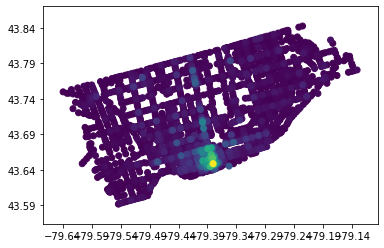

In [59]:
fig = plt.figure()

# scatter plot of the data
plt.scatter(x=traffic_df['Longitude'].tolist(), y=traffic_df['Latitude'].tolist(), c=traffic_df['PedestrianVolume'].tolist())
plt.xticks(np.round(np.arange(min(traffic_df['Longitude']), max(traffic_df['Longitude']), 0.05), 2))
plt.yticks(np.round(np.arange(min(traffic_df['Latitude']), max(traffic_df['Latitude']), 0.05), 2))

# map
mplleaflet.display()

#plt.show()

In the plot above, we can see that the busiest intersections in terms of pedestrian volume are in the region centred around -79.39 longitude and 43.64 latitude. This makes sense since that is the core of the city. We will be using this region to explore its venues and predict the popularity of new venues.

In the map below you can see the bounding box for the region that we will be looking at. That is, we will only use intersections and venues that are located in this region.

In [ ]:
lat = 43.6525
lng = -79.381667
m = 5000  # metres
a = 6378137  # Radius of earth at equator (m)
e2 = 0.00669437999014  # eccentricity squared
r = np.pi / 180  # convert to radians

# distance of 1 degree latitude
d1 = r * a * (1 - e2) / (1 - e2 * np.sin(lat * r) ** 2) ** (3 / 2)

# distance of 1 degree longitude
d2 = r * a * np.cos(lat * r) / np.sqrt(1 - e2 * np.sin(lat * r) ** 2)

# Bounding box coordinates
min_lat, max_lat = lat - m / d1, lat + m / d1
min_lng, max_lng = lng - m / d2, lng + m / d2

print(min_lat, min_lng, max_lat, max_lng)

In [ ]:
print(traffic_df.shape)
lat_bool = traffic_df.Latitude.between(min_lat, max_lat)
lng_bool = traffic_df.Longitude.between(min_lng, max_lng)

traffic_df = traffic_df[lat_bool & lng_bool]
print(traffic_df.shape)

In [ ]:
def CreateMap(lat, lng, zoom_start=12, with_colour=False, n_clusters=0):
    # if with_colour = True, you must specify the number of clusters
    
    # create map
    m = folium.Map(location=[43.65, -79.38], zoom_start=zoom_start)

    if with_colour:
        # set color scheme for the clusters
        x = np.arange(n_clusters)
        ys = [i + x + (i*x)**2 for i in range(n_clusters)]
        colors_array = cm.YlOrRd(np.linspace(0, 1, len(ys)))
        rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    if with_colour:
        for lat, lng, main_st, side_st, cluster in zip(traffic_df['Latitude'],
                                                       traffic_df['Longitude'],
                                                       traffic_df['Main'], 
                                                       traffic_df['Side1'],
                                                       traffic_df['ClusterLabel']):

            label = folium.Popup(str(main_st) + ' & ' + str(side_st), parse_html=True)
            folium.CircleMarker(
                [lat, lng],
                radius=3,
                popup=label,
                color=rainbow[cluster-1],
                fill=True,
                fill_opacity=0.7).add_to(m)
    else:
        for lat, lng, main_st, side_st in zip(traffic_df['Latitude'],
                                              traffic_df['Longitude'],
                                              traffic_df['Main'], 
                                              traffic_df['Side1']):

            label = folium.Popup(str(main_st) + ' & ' + str(side_st), parse_html=True)
            folium.CircleMarker(
                [lat, lng],
                radius=3,
                popup=label,
                fill=True,
                fill_opacity=0.7).add_to(m)

    return m

In [ ]:
CreateMap(43.65, -79.38)

In [ ]:
features = ['Latitude', 'Longitude']
feature_set = traffic_df[features]

In order to determine if the features need to be normalized, let's look at the range of each feature.

In [ ]:
traffic_df[features].max() - traffic_df[features].min()

We see that the ranges differ significantly, so we will normalize our data to get a more accurate clustering.

In [ ]:
x = feature_set.values
min_max_scaler = MinMaxScaler()
feature_mtx = min_max_scaler.fit_transform(x)
feature_mtx[0:5]

Now we calculate the distance matrix of the feature matrix. We use the _cityblock_ metric to calculate the city block distance between the points.

In [ ]:
# calculate the distance between points
dist_array = distance.pdist(feature_mtx, metric='cityblock')

# calculate the distance matrix to be used in hierarchical clustering
dist_matrix = distance.squareform(dist_array)
dist_matrix

Now we want to use the distance matrix to create a hierarchical clustering of the intersections using their proximity to each other. The goal is to cluster intersections that are close to each other in order to later retrieve the venues that are inside each cluster.

In [ ]:
# ignore warning when performing the hierarchical clustering
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    Z = hierarchy.linkage(dist_matrix, method='average')

In [ ]:
max_clusters = 10
clusters = hierarchy.fcluster(Z, max_clusters, criterion='maxclust')

traffic_df['ClusterLabel'] = clusters

In [ ]:
CreateMap(43.65, -79.38, with_colour=True, n_clusters=max_clusters, zoom_start = 13)

In [ ]:
traffic_df.loc[traffic_df['Main'] == 'STEELES AVE E'].loc[traffic_df['Side1'] == 'PICKERING TOWN LINE']

In [ ]:
traffic_df.drop(index=51, inplace=True)

In [ ]:
fig, ax = plt.subplots()
traffic_df.plot(kind='scatter', x='Longitude', y='Latitude', c='PedestrianVolume', colormap='YlOrRd', ax=ax, figsize=(15,10))

In [ ]:
traffic_df.head()